In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
import seaborn as sns
from lightgbm import LGBMRegressor, Dataset, cv, early_stopping
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    GridSearchCV,
    train_test_split)
from lightgbm import plot_tree
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error, 
    r2_score, 
    mean_absolute_percentage_error)
from sklearn.pipeline import Pipeline
import joblib

In [2]:
path = 'Dataset2.xlsx'
df = pd.read_excel(path)
df

,Дата и время,Электропотребление
0,2019-01-01 00:00:00.000,215.19100
1,2019-01-01 01:00:00.000,202.23900
2,2019-01-01 02:00:00.000,188.46200
3,2019-01-01 02:59:59.985,179.27600
4,2019-01-01 03:59:59.980,173.03500
...,...,...
39379,2023-06-29 19:00:32.855,176.54199
39380,2023-06-29 20:00:32.860,188.42859
39381,2023-06-29 21:00:32.865,183.35104
39382,2023-06-29 22:00:32.870,170.04759


In [3]:
df['Электропотребление'].describe()

count    39384.000000
mean       184.463841
std         43.164005
min         93.956000
25%        156.352000
50%        179.881500
75%        213.911500
max        321.055000
Name: Электропотребление, dtype: float64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39384 entries, 0 to 39383
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Дата и время        39384 non-null  datetime64[ns]
 1   Электропотребление  39384 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 615.5 KB


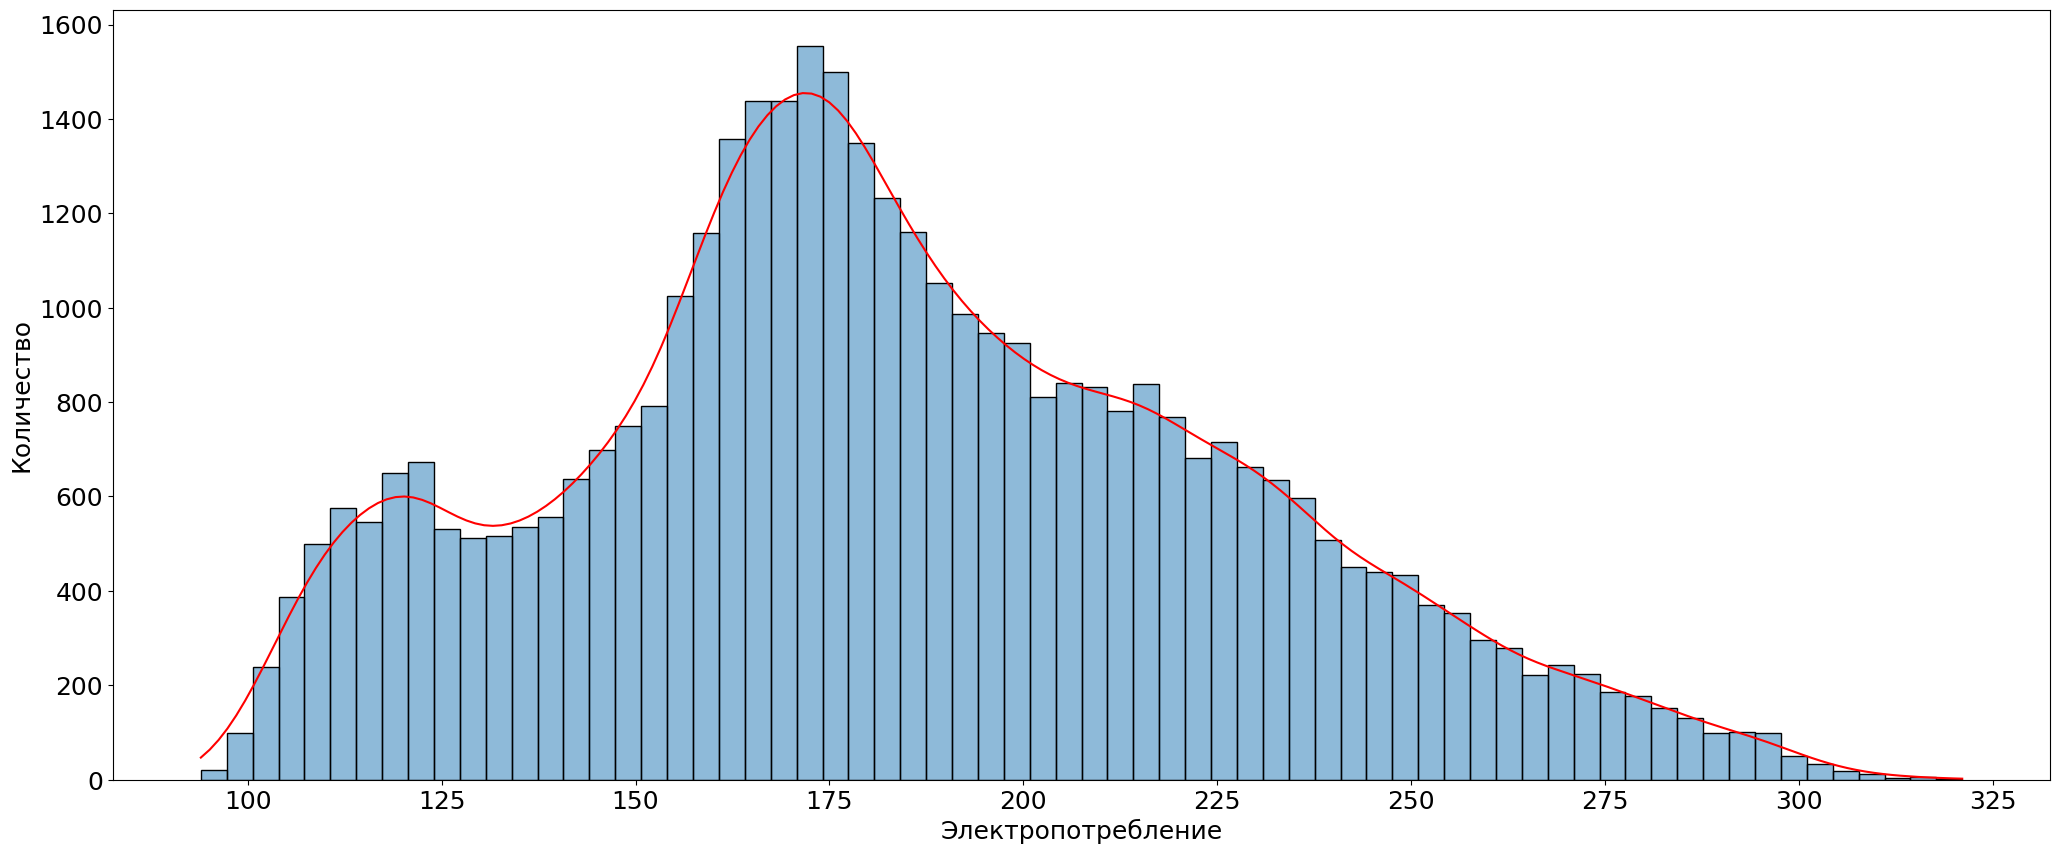

In [5]:
plt.figure(figsize=(25, 10))
ax = sns.histplot(df['Электропотребление'], kde=True)
ax.lines[0].set_color('red')
plt.xlabel('Электропотребление', fontsize=18)
plt.xticks(np.arange(100, 350, 25), fontsize=18)
plt.ylabel('Количество', fontsize=18)
plt.yticks(np.arange(0, 1800, 200), fontsize=18)
plt.show()

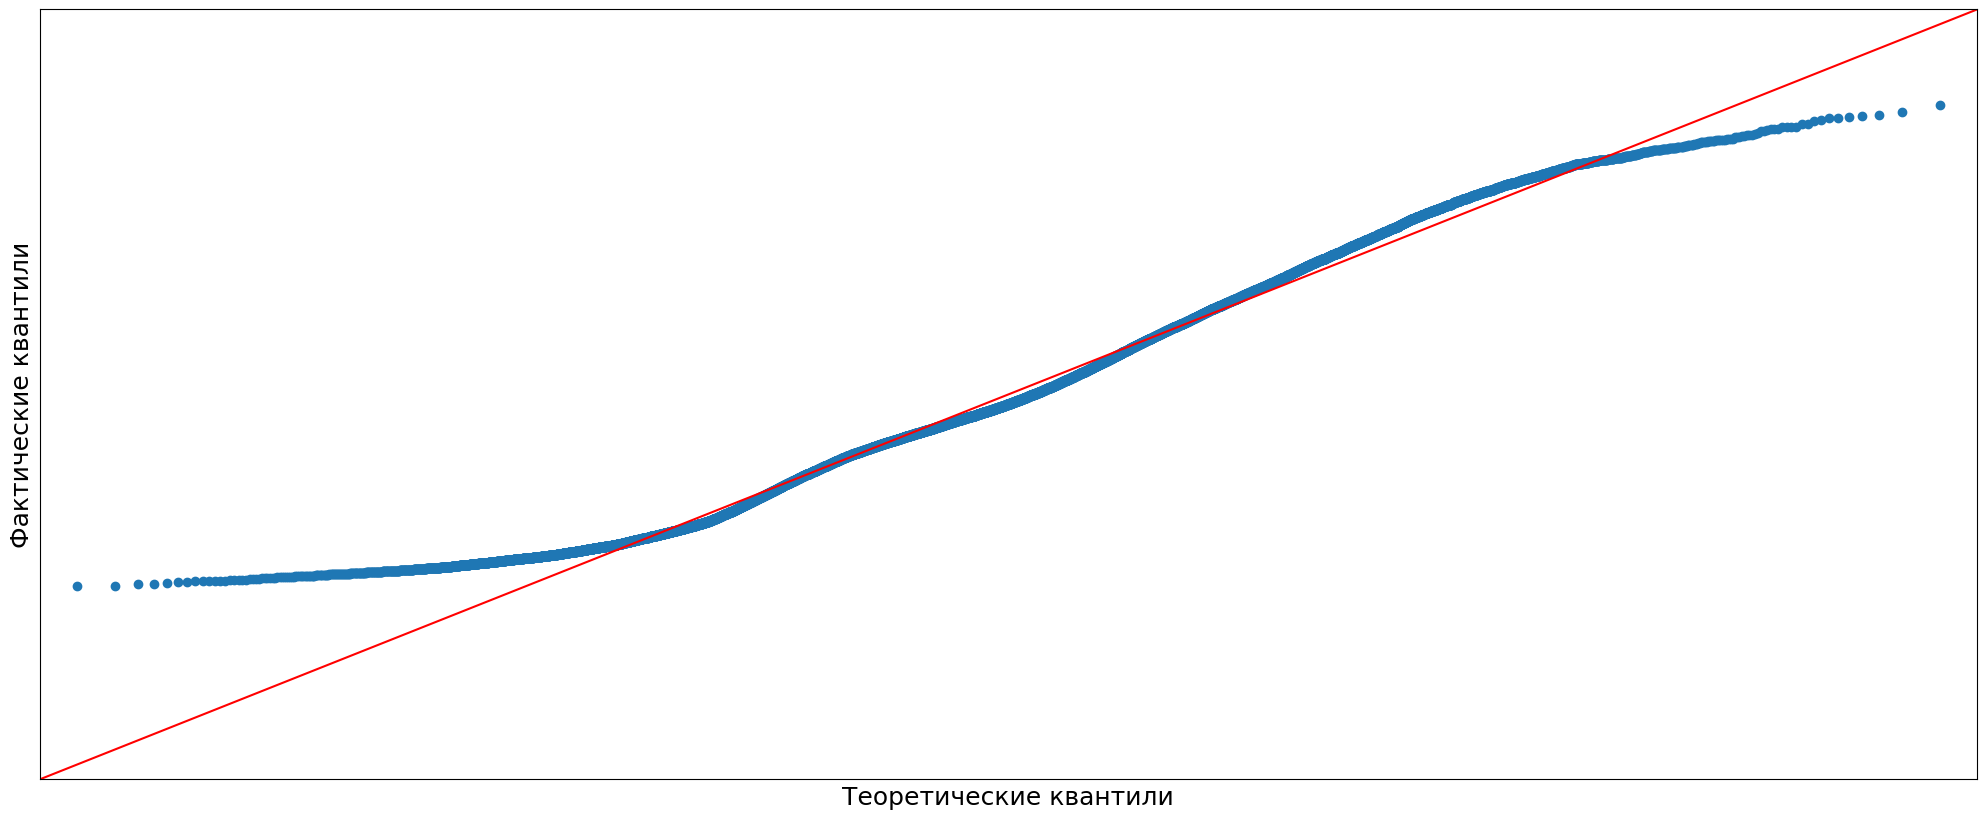

In [12]:
fig, ax = plt.subplots(figsize=(25, 10))
sm.qqplot(df['Электропотребление'], line="45", fit=True, ax=ax)
ax.yaxis.set_major_locator(NullLocator())
ax.xaxis.set_major_locator(NullLocator())
plt.xlabel('Теоретические квантили', fontsize=18)
plt.ylabel('Фактические квантили', fontsize=18)
plt.show()

<h2>
    Распределение отлично от нормального.<br>
    Гипотеза о нормальности распределения на больших выборках почти всегда отклоняется.<br>
    Функция scipy.stats.shapiro пишет, что при выборке больше 5000 результат оценки может быть неточным.
</h2>

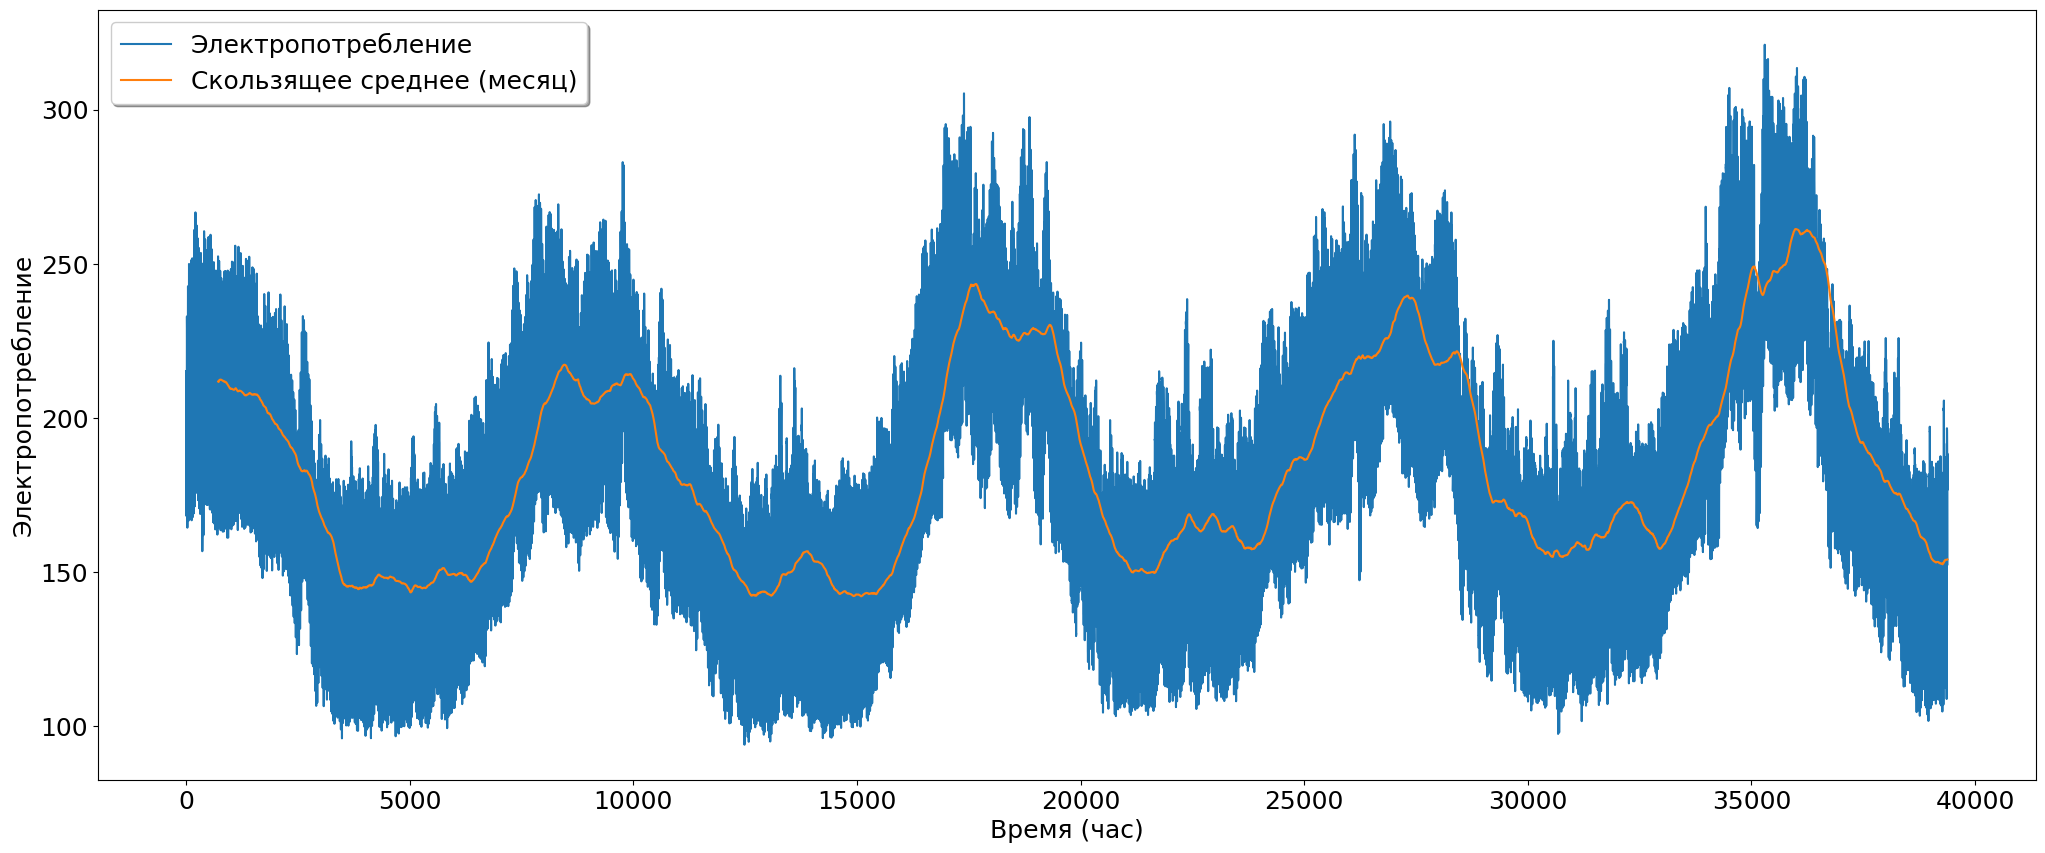

In [6]:
moving_average = df['Электропотребление'].rolling(24 * 30).mean()
plt.figure(figsize=(25, 10))
plt.plot(df['Электропотребление'], label='Электропотребление')
plt.plot(moving_average, label='Скользящее среднее (месяц)')
plt.ylabel('Электропотребление', fontsize=18)
plt.yticks(np.arange(100, 350, 50), fontsize=18)
plt.xlabel('Время (час)', fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc='best', shadow=True, fontsize=18)
plt.show()

<h2>В ряде отсутствует ярко выраженный тренд.</h2>

In [9]:
p_value_c = adfuller(
    df['Электропотребление'].dropna(),
    regression='c')[1]
p_value_ct = adfuller(
    df['Электропотребление'].dropna(),
    regression='ct')[1]
p_value_ctt = adfuller(
    df['Электропотребление'].dropna(),
    regression='ctt')[1]
alpha = 0.05 / 3  # уровень значимости вместе с поправкой Бонферрони
print(f'{p_value_c=:.3f} и {alpha=:.3f}')
print(f'{p_value_ct=:.3f} и {alpha=:.3f}')
print(f'{p_value_ctt=:.3f} и {alpha=:.3f}')

p_value_c=0.001 и alpha=0.017
p_value_ct=0.003 и alpha=0.017
p_value_ctt=0.013 и alpha=0.017


<h2>С 95-% вероятностью можно утверждать, что ряд является стационарным.</h2>

<h1><b>Анализ на выбросы</b></h1>

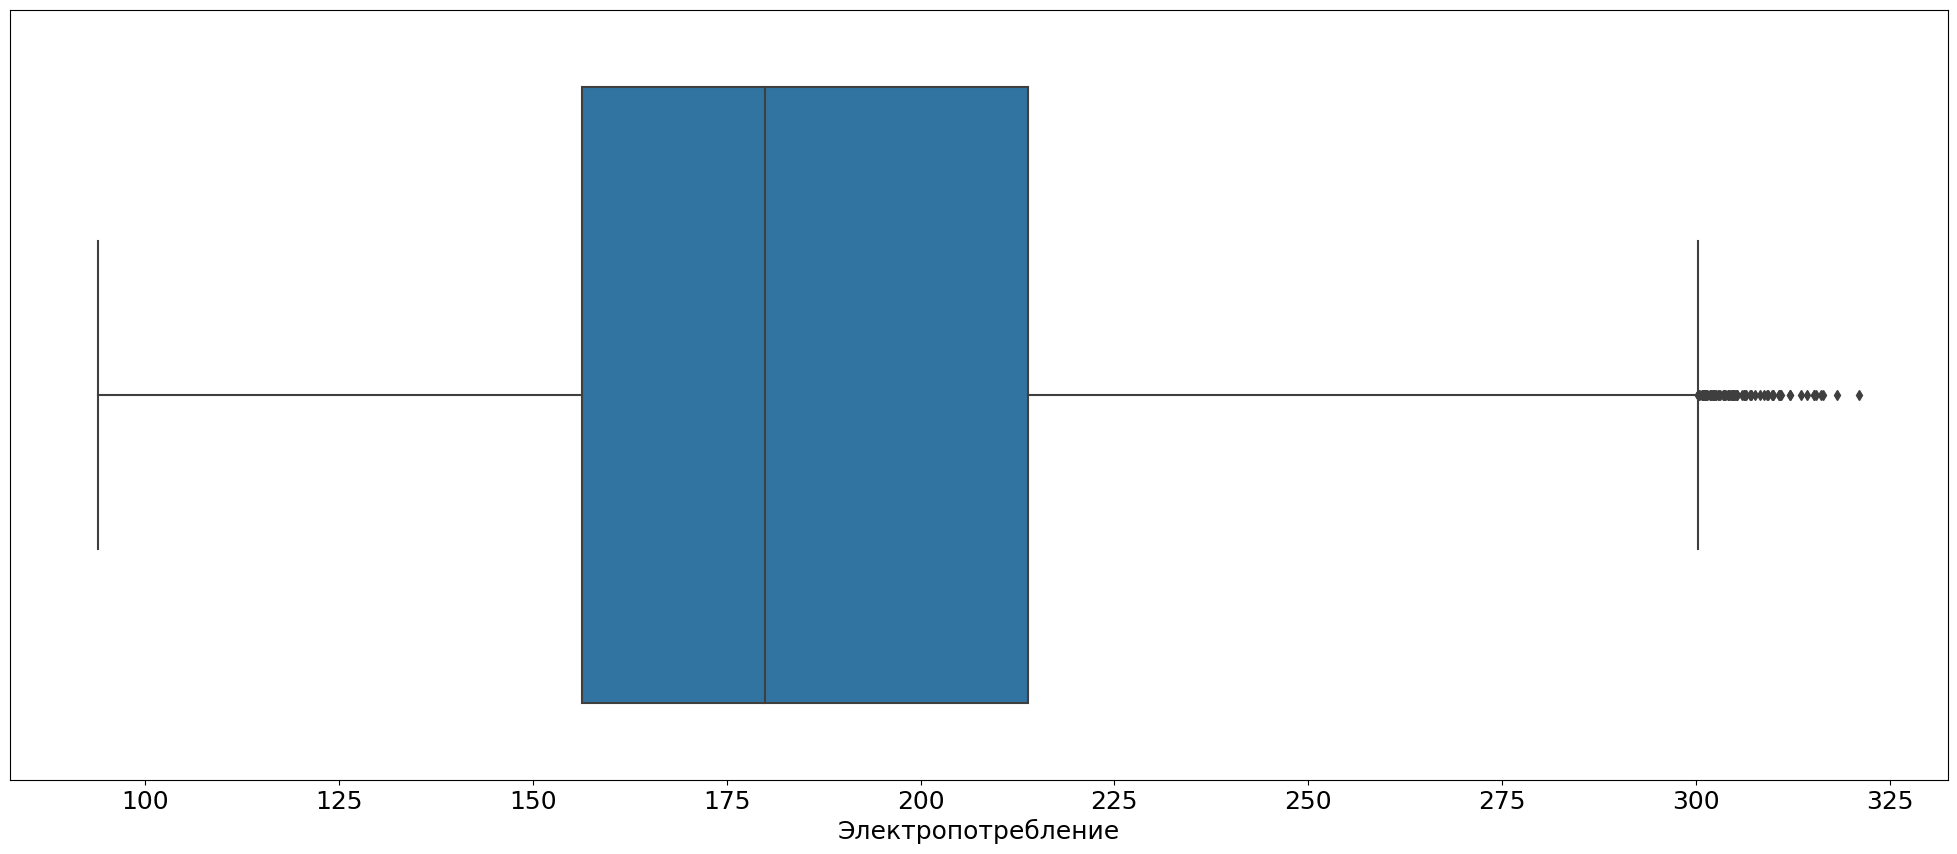

In [10]:
plt.figure(figsize=(25, 10))
ax1 = sns.boxplot(df['Электропотребление'], orient='h')
ax1.yaxis.set_major_locator(NullLocator())
plt.xlabel('Электропотребление', fontsize=18)
plt.xticks(np.arange(100, 350, 25), fontsize=18)
plt.show()

In [11]:
IQR = df['Электропотребление'].quantile(q=0.75) - df['Электропотребление'].quantile(q=0.25)
rh = df['Электропотребление'].quantile(q=0.75) + IQR * 1.5
round(rh, 3)

300.251

In [12]:
df_outliers = df[df['Электропотребление'] > rh]
df_outliers

,Дата и время,Электропотребление
17393,2020-12-25 16:59:59.525,305.278
17394,2020-12-25 17:59:59.525,300.871
34481,2022-12-07 17:00:08.595,304.700
34504,2022-12-08 16:00:08.710,301.042
34505,2022-12-08 17:00:08.715,307.041
...,...,...
36202,2023-02-17 10:00:17.200,302.484
36203,2023-02-17 11:00:17.205,303.531
36210,2023-02-17 18:00:17.240,309.860
36211,2023-02-17 19:00:17.245,306.978


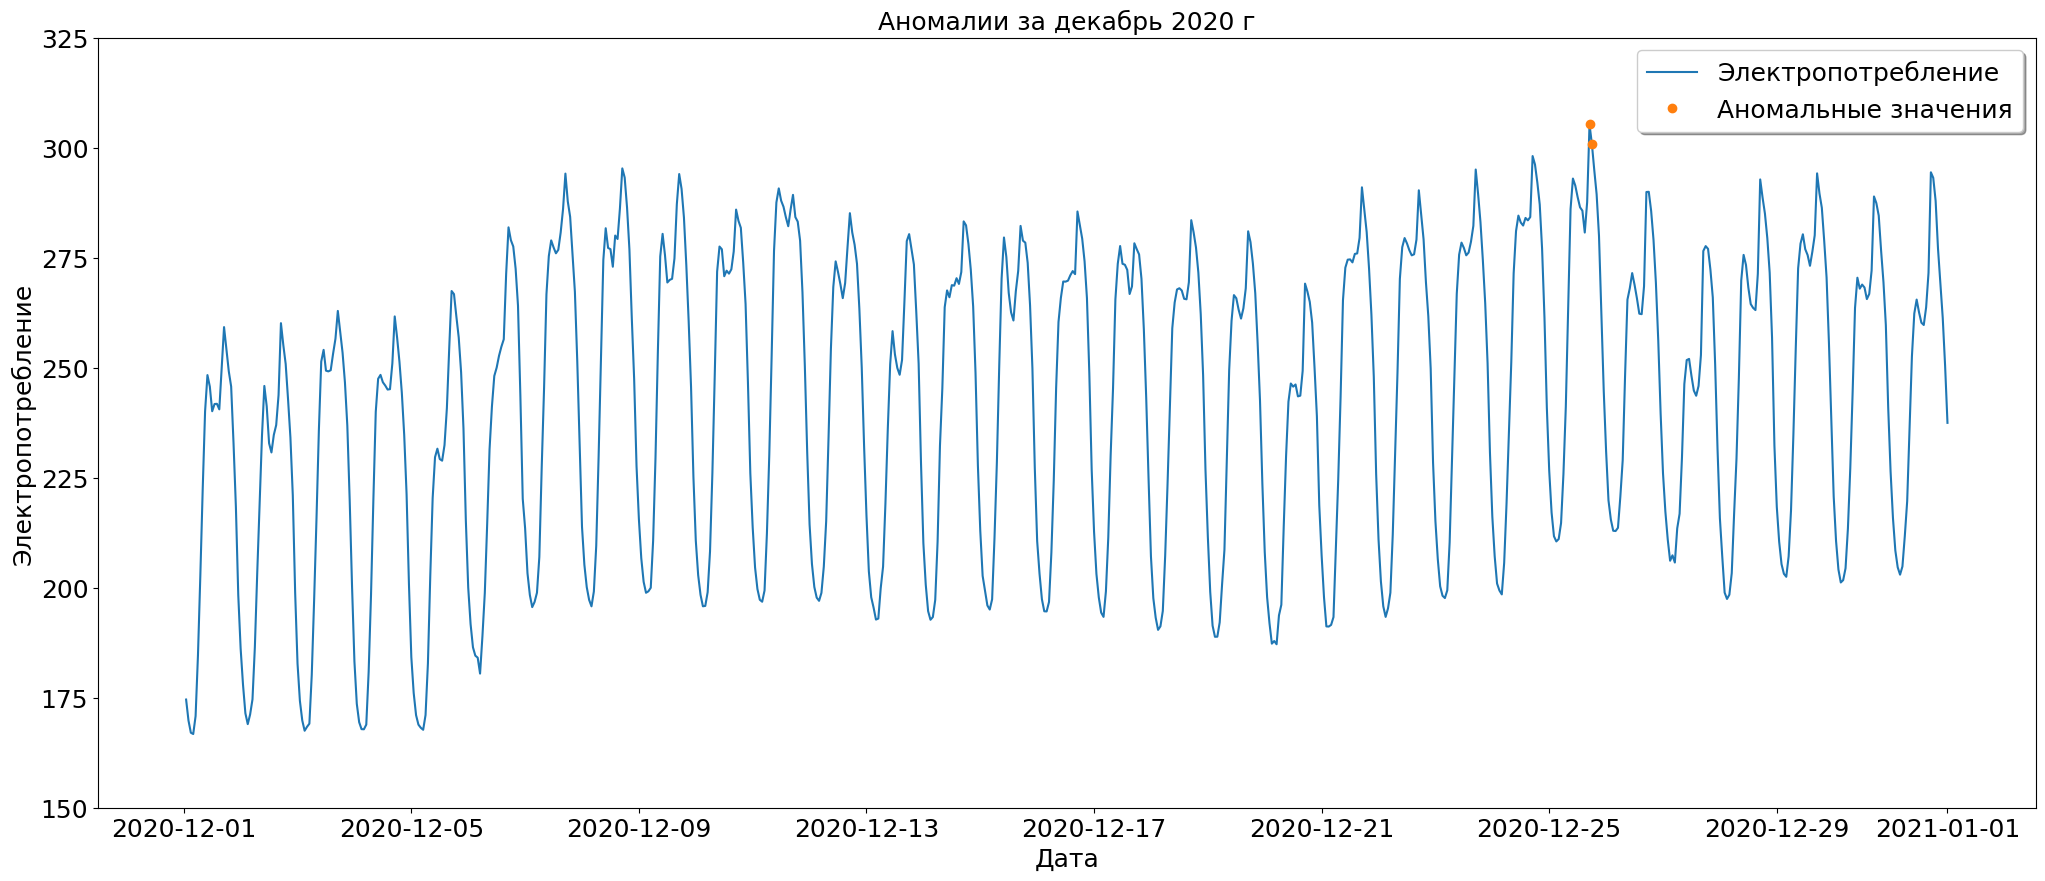

In [15]:
mask1 = (df['Дата и время'] > '2020-12-01') & (df['Дата и время'] < '2021-01-01')
plt.figure(figsize=(25, 10))
plt.title('Аномалии за декабрь 2020 г', fontsize=18)
plt.plot(
    df['Дата и время'][mask1],
    df['Электропотребление'][mask1],
    label='Электропотребление')
plt.plot(
    df_outliers['Дата и время'][mask1],
    df_outliers['Электропотребление'][mask1],
    label='Аномальные значения', marker='o', linestyle='')
plt.ylabel('Электропотребление', fontsize=18)
plt.yticks(np.arange(150, 350, 25), fontsize=18)
plt.xlabel('Дата', fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc='best', shadow=True, fontsize=18)
plt.show()

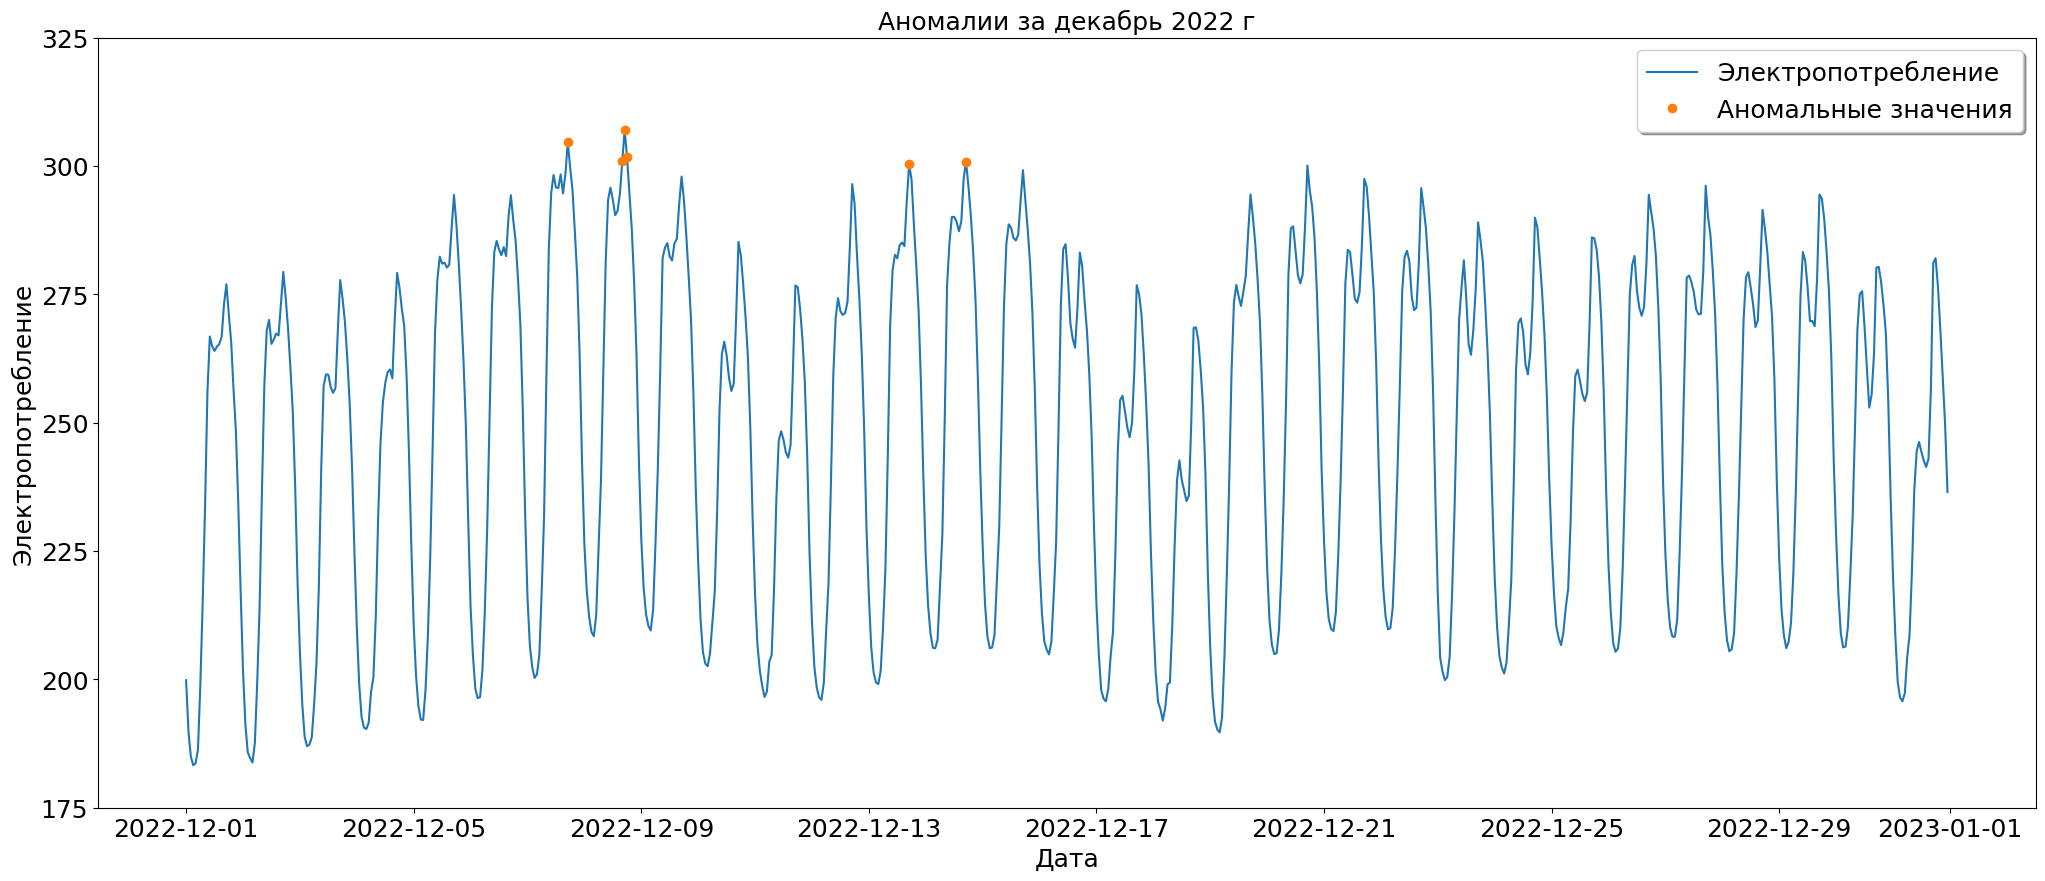

In [16]:
mask2 = (df['Дата и время'] > '2022-12-01') & (df['Дата и время'] < '2023-01-01')
plt.figure(figsize=(25, 10))
plt.title('Аномалии за декабрь 2022 г', fontsize=18)
plt.plot(
    df['Дата и время'][mask2],
    df['Электропотребление'][mask2],
    label='Электропотребление')
plt.plot(
    df_outliers['Дата и время'][mask2],
    df_outliers['Электропотребление'][mask2],
    label='Аномальные значения', marker='o', linestyle='')
plt.ylabel('Электропотребление', fontsize=18)
plt.yticks(np.arange(175, 350, 25), fontsize=18)
plt.xlabel('Дата', fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc='best', shadow=True, fontsize=18)
plt.show()

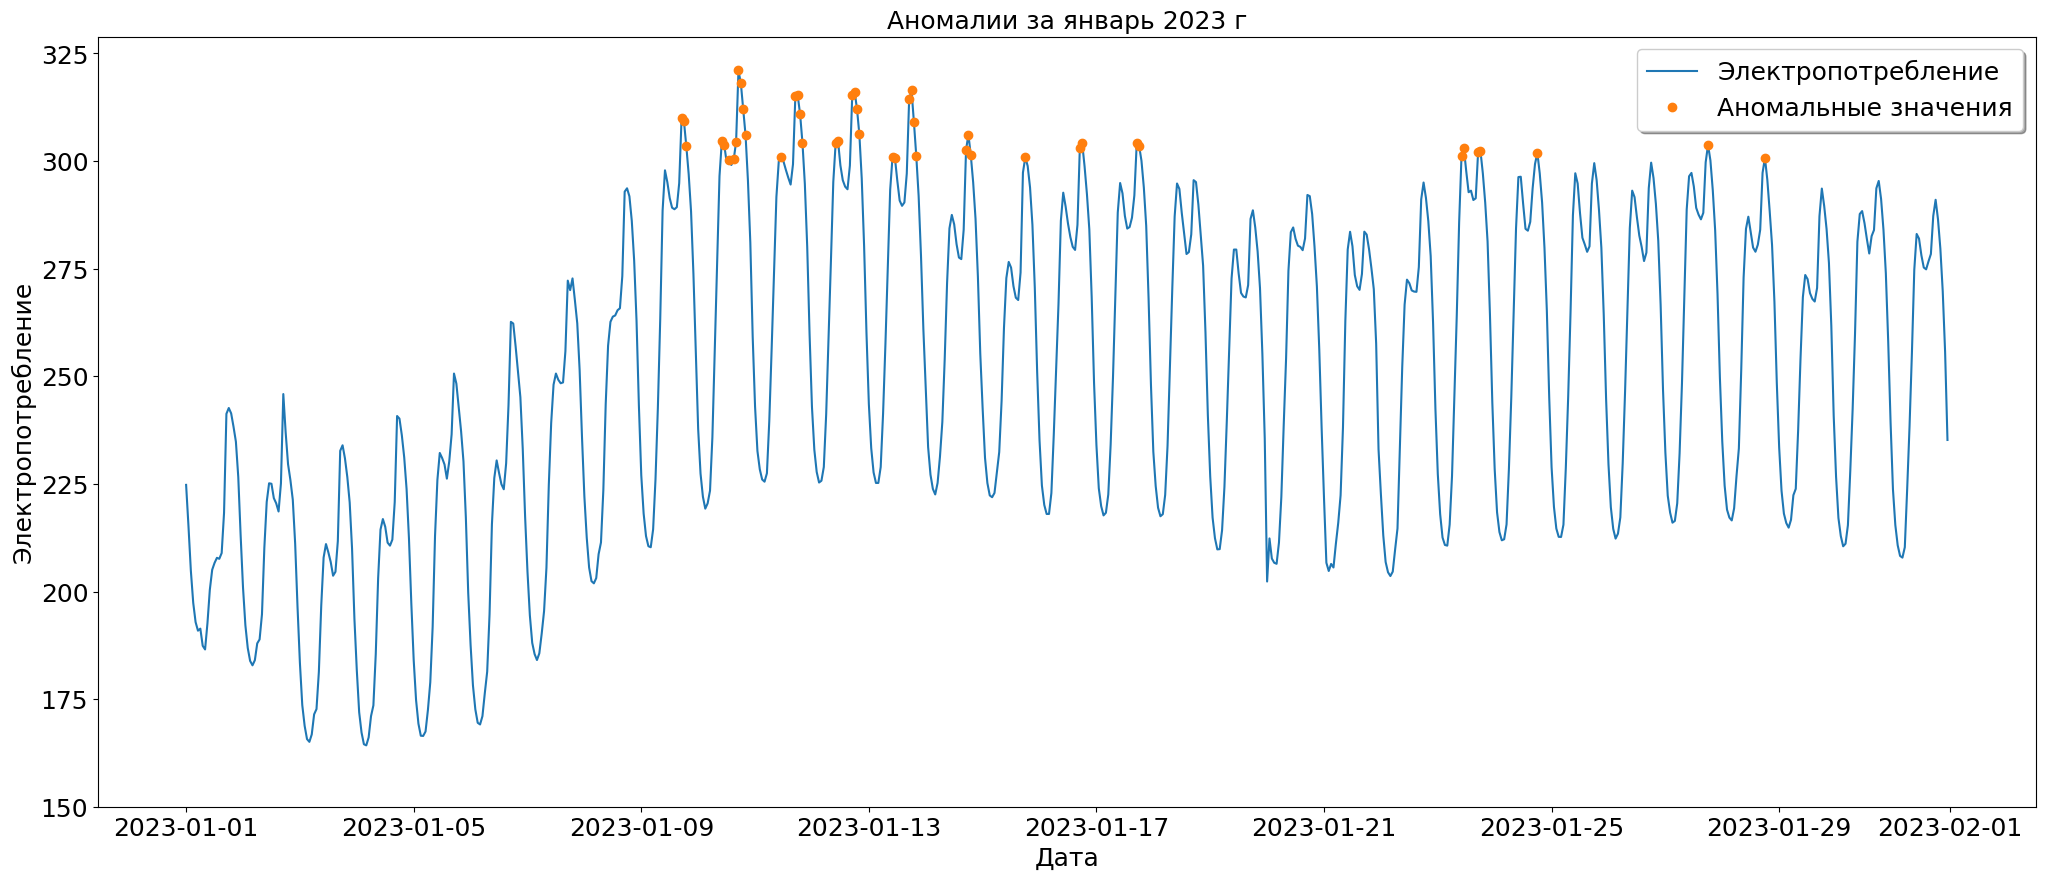

In [17]:
mask3 = (df['Дата и время'] > '2023-01-01') & (df['Дата и время'] < '2023-02-01')
plt.figure(figsize=(25, 10))
plt.title('Аномалии за январь 2023 г', fontsize=18)
plt.plot(
    df['Дата и время'][mask3],
    df['Электропотребление'][mask3],
    label='Электропотребление')
plt.plot(
    df_outliers['Дата и время'][mask3],
    df_outliers['Электропотребление'][mask3],
    label='Аномальные значения', marker='o', linestyle='')
plt.ylabel('Электропотребление', fontsize=18)
plt.yticks(np.arange(150, 350, 25), fontsize=18)
plt.xlabel('Дата', fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc='best', shadow=True, fontsize=18)
plt.show()

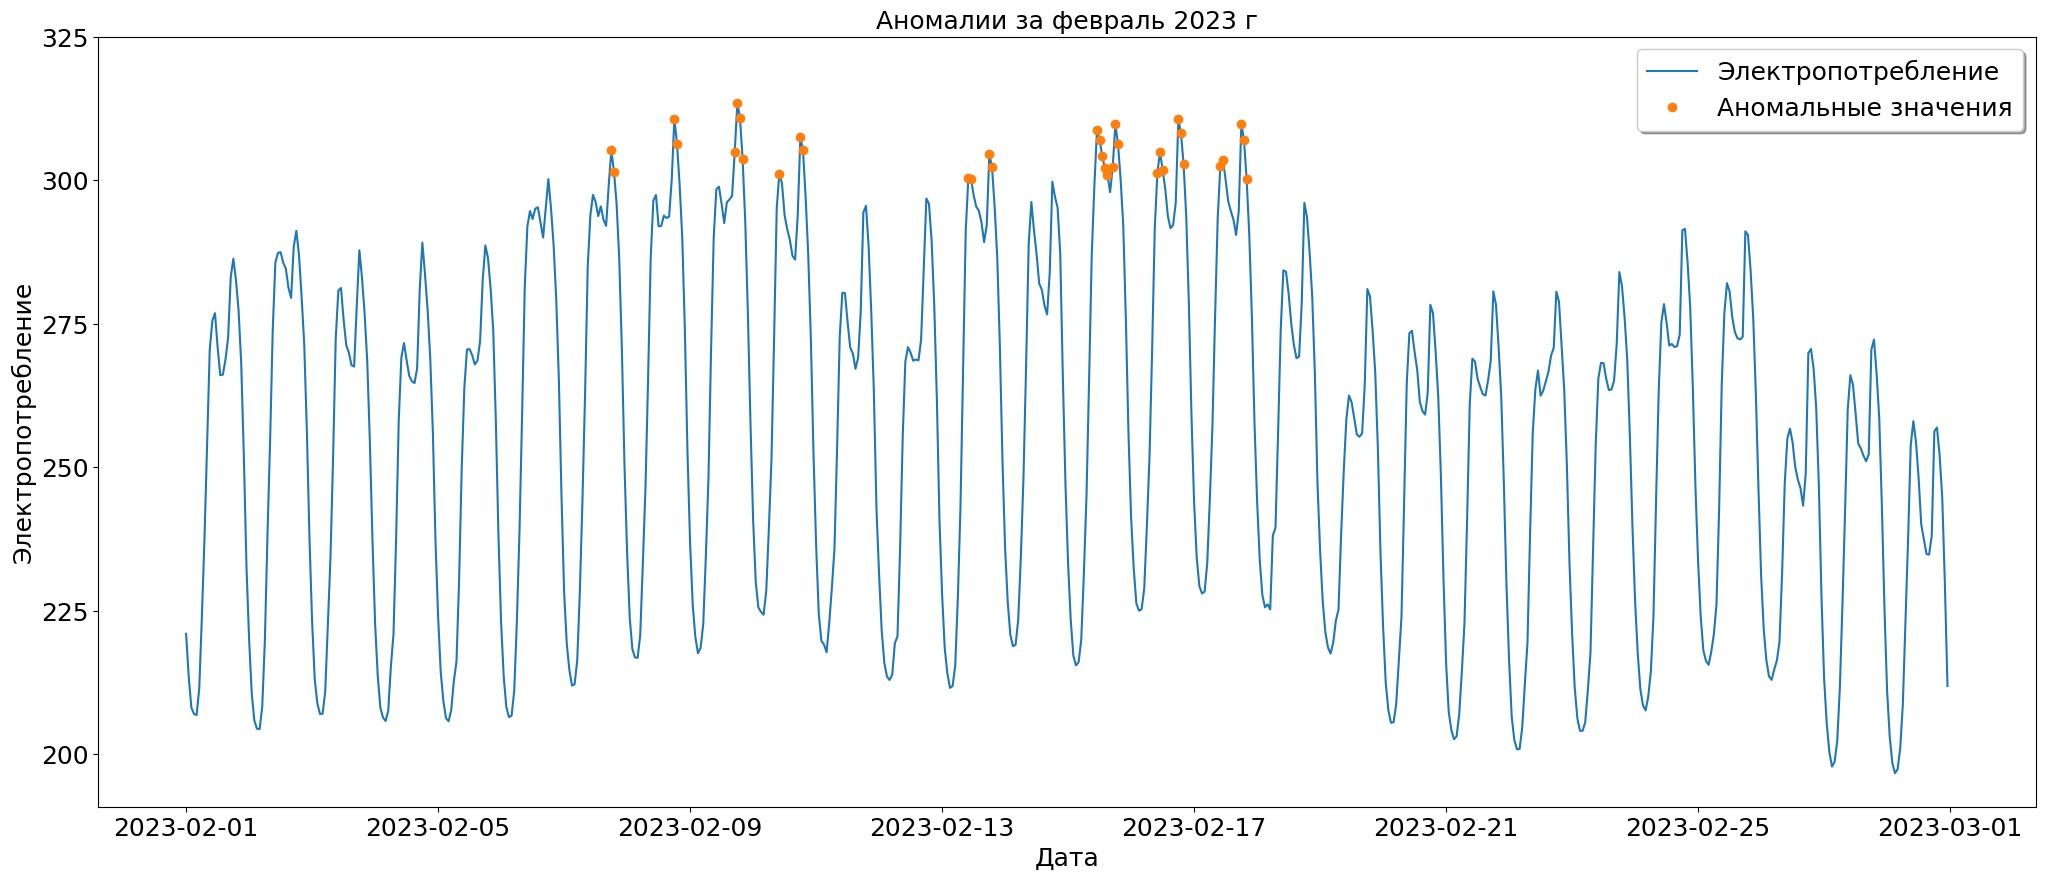

In [18]:
mask4 = (df['Дата и время'] > '2023-02-01') & (df['Дата и время'] < '2023-03-01')
plt.figure(figsize=(25, 10))
plt.title('Аномалии за февраль 2023 г', fontsize=18)
plt.plot(
    df['Дата и время'][mask4],
    df['Электропотребление'][mask4],
    label='Электропотребление')
plt.plot(
    df_outliers['Дата и время'][mask4],
    df_outliers['Электропотребление'][mask4],
    label='Аномальные значения', marker='o', linestyle='')
plt.ylabel('Электропотребление', fontsize=18)
plt.yticks(np.arange(200, 350, 25), fontsize=18)
plt.xlabel('Дата', fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc='best', shadow=True, fontsize=18)
plt.show()

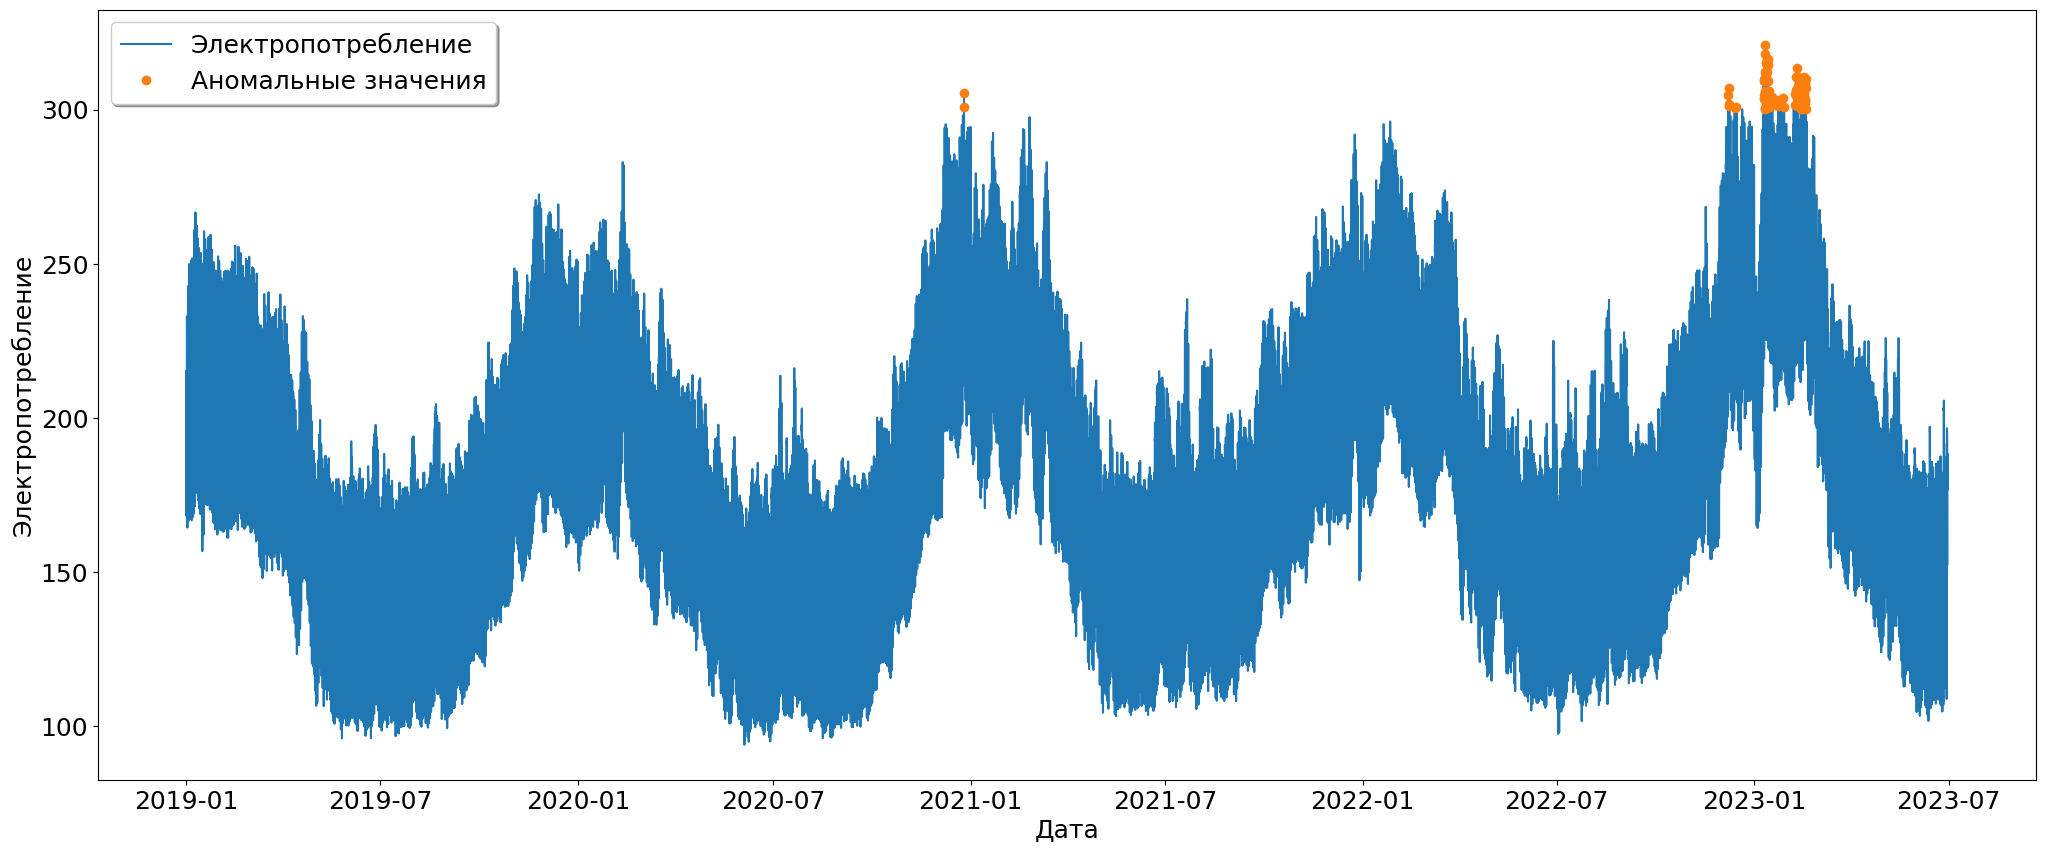

In [19]:
plt.figure(figsize=(25, 10))
plt.plot(
    df['Дата и время'],
    df['Электропотребление'],
    label='Электропотребление')
plt.plot(
    df_outliers['Дата и время'],
    df_outliers['Электропотребление'],
    label='Аномальные значения', marker='o', linestyle='')
plt.ylabel('Электропотребление', fontsize=18)
plt.yticks(np.arange(100, 350, 50), fontsize=18)
plt.xlabel('Дата', fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc='best', shadow=True, fontsize=18)
plt.show()

In [20]:
outlier_count = df_outliers['Электропотребление'].count()
outlier_count

86

In [21]:
round(outlier_count / len(df.dropna()) * 100, 3)

0.218

<h2>0.218 % аномальных значений и все они приходятся на зимний период.</h2>

<h1><b>Feature Engineering</b></h1>

In [3]:
def create_times_of_day(data):
    """Создает столбец период времени суток.
    Строки группируются по часам.
    
    0 (ночь) [0 - 5];
    1 (утро) [6 - 11];
    2 (обед) [12 - 17];
    3 (вечер) [18 - 23].
    
    Аргументы:
        data (pandas.DataFrame): Входные данные клиента.
        
    Возвращает:
        pandas.Series: Серия с периодами времени суток.
    """
    day_periods = pd.cut(
        data['Дата и время'].dt.hour,
        bins=4,
        labels=range(4))
    return day_periods

In [4]:
def preprocessing() -> None:
    """Конструирование признаков с переводом их в нужный формат.
    """
    df['Дата и время'] = df['Дата и время'].dt.round('H')

    df['Час'] = df['Дата и время'].dt.hour.astype('category')
    df['Период времени суток'] = create_times_of_day(df).astype('category')

    df['День недели'] = df['Дата и время'].dt.dayofweek.astype('category')
    df['Выходной'] =  df['День недели'].isin([5, 6]).astype('int').astype('category')
    df['День в году'] = df['Дата и время'].dt.dayofyear
     
    df['Месяц'] = df['Дата и время'].dt.month.astype('category') 

    df['Электропотребление лаг 1 день'] = df['Электропотребление'].shift(24)
    df['Электропотребление лаг 7 дней'] = df['Электропотребление'].shift(24 * 7)

    df.dropna(inplace=True)

In [5]:
preprocessing()

In [6]:
df

,Дата и время,Электропотребление,Час,Период времени суток,День недели,Выходной,День в году,Месяц,Электропотребление лаг 1 день,Электропотребление лаг 7 дней
168,2019-01-08 00:00:00,195.69700,0,0,1,0,8,1,191.298,215.191
169,2019-01-08 01:00:00,184.35700,1,0,1,0,8,1,179.960,202.239
170,2019-01-08 02:00:00,174.13000,2,0,1,0,8,1,172.706,188.462
171,2019-01-08 03:00:00,170.22800,3,0,1,0,8,1,169.160,179.276
172,2019-01-08 04:00:00,169.02300,4,0,1,0,8,1,167.794,173.035
...,...,...,...,...,...,...,...,...,...,...
39379,2023-06-29 19:00:00,176.54199,19,3,3,0,180,6,171.040,167.809
39380,2023-06-29 20:00:00,188.42859,20,3,3,0,180,6,183.232,177.173
39381,2023-06-29 21:00:00,183.35104,21,3,3,0,180,6,177.985,172.780
39382,2023-06-29 22:00:00,170.04759,22,3,3,0,180,6,164.705,158.533


In [136]:
y = df['Электропотребление']
X = df.drop(columns=['Электропотребление', 'Дата и время'], axis=0)
X

,Час,Период времени суток,День недели,Выходной,День в году,Месяц,Электропотребление лаг 1 день,Электропотребление лаг 7 дней
168,0,0,1,0,8,1,191.298,215.191
169,1,0,1,0,8,1,179.960,202.239
170,2,0,1,0,8,1,172.706,188.462
171,3,0,1,0,8,1,169.160,179.276
172,4,0,1,0,8,1,167.794,173.035
...,...,...,...,...,...,...,...,...
39379,19,3,3,0,180,6,171.040,167.809
39380,20,3,3,0,180,6,183.232,177.173
39381,21,3,3,0,180,6,177.985,172.780
39382,22,3,3,0,180,6,164.705,158.533


In [137]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    shuffle=False, 
    test_size=0.2)
X_train

,Час,Период времени суток,День недели,Выходной,День в году,Месяц,Электропотребление лаг 1 день,Электропотребление лаг 7 дней
168,0,0,1,0,8,1,191.298,215.191
169,1,0,1,0,8,1,179.960,202.239
170,2,0,1,0,8,1,172.706,188.462
171,3,0,1,0,8,1,169.160,179.276
172,4,0,1,0,8,1,167.794,173.035
...,...,...,...,...,...,...,...,...
31535,23,3,5,1,218,8,151.210,160.502
31536,0,0,6,1,219,8,138.811,145.668
31537,1,0,6,1,219,8,130.961,133.815
31538,2,0,6,1,219,8,126.759,126.943


In [138]:
categorical_features = ['Период времени суток', 'Час', 'Месяц', 'День недели', 'Выходной', 'День в году']
categorical_features

['Период времени суток',
 'Час',
 'Месяц',
 'День недели',
 'Выходной',
 'День в году']

<h1><b>Подбор гиперпараметров</b></h1>

<h2>init n_estimators</h2>

In [142]:
X_trainLGB = Dataset(
    data=X_train, 
    label=y_train, 
    categorical_feature=categorical_features)

main_params = {'objective': 'regression', 'force_col_wise': 'true', 'random_state':1}
tscv = TimeSeriesSplit(test_size=24 * 30 * 3, n_splits=5, gap=24 * 5)
    
cv_results = cv(
        main_params,
        X_trainLGB,
        num_boost_round=5000,
        folds=tscv,
        stratified=False,
        shuffle=False,
        metrics='mae',
        categorical_feature=categorical_features,
        callbacks=[early_stopping(50)],
        eval_train_metric=True
        )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 20452, number of used features: 8
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 22612, number of used features: 8
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 24772, number of used features: 8
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 26932, number of used features: 8
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 29092, number of used features: 8
[LightGBM] [Info] Start training from score 179.866029
[LightGBM] [Info] Start training from score 177.835723
[LightGBM] [Info] Start training from score 177.344914
[LightGBM] [Info] Start training from score 180.847562
[LightGBM] [Info] Start training from score 182.518670
Training until valid

<h2>max_depth</h2>

In [116]:
lgb_model = LGBMRegressor(
    n_estimators=58,
    random_state=1,
    bagging_freq=1,
    n_jobs=-1)
params = {
    'max_depth': range(5, 21)
    }

grid = GridSearchCV(
    lgb_model,
    params,
    scoring='neg_mean_absolute_error',
    cv=tscv
)
grid.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging

GridSearchCV(cv=TimeSeriesSplit(gap=120, max_train_size=None, n_splits=5, test_size=2160),
             estimator=LGBMRegressor(bagging_freq=1, n_estimators=58,
                                     random_state=1),
             param_grid={'max_depth': range(5, 21)},
             scoring='neg_mean_absolute_error')

In [117]:
grid.best_params_

{'max_depth': 10}

<h2>update n_estimators</h2>

In [143]:
main_params['max_depth'] = 10
main_params

{'objective': 'regression',
 'force_col_wise': 'true',
 'random_state': 1,
 'max_depth': 10}

In [144]:
cv_results = cv(
        main_params,
        X_trainLGB,
        num_boost_round=5000,
        folds=tscv,
        stratified=False,
        shuffle=False,
        metrics='mae',
        categorical_feature=categorical_features,
        callbacks=[early_stopping(50)],
        eval_train_metric=True
        )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 20452, number of used features: 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 22612, number of used features: 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 24772, number of used features: 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_

<h1><b>Обучение</b></h1>

In [109]:
lgbm = LGBMRegressor(
    n_estimators=57,
    max_depth=10,
    bagging_freq=1,
    importance_type='gain',
    random_state=1,
    n_jobs=-1).fit(X_train, y_train)

In [110]:
data = pd.DataFrame(
    data=lgbm.feature_importances_,
    index=X_train.columns,
    columns=["information gain"]).sort_values(
    by="information gain",
    ascending=False)
data

,information gain
Электропотребление лаг 1 день,2.685914e+08
Электропотребление лаг 7 дней,3.091221e+06
День недели,1.271155e+06
Час,1.029471e+06
День в году,9.667741e+05
Выходной,7.329460e+05
Месяц,4.360300e+05
Период времени суток,2.418164e+05


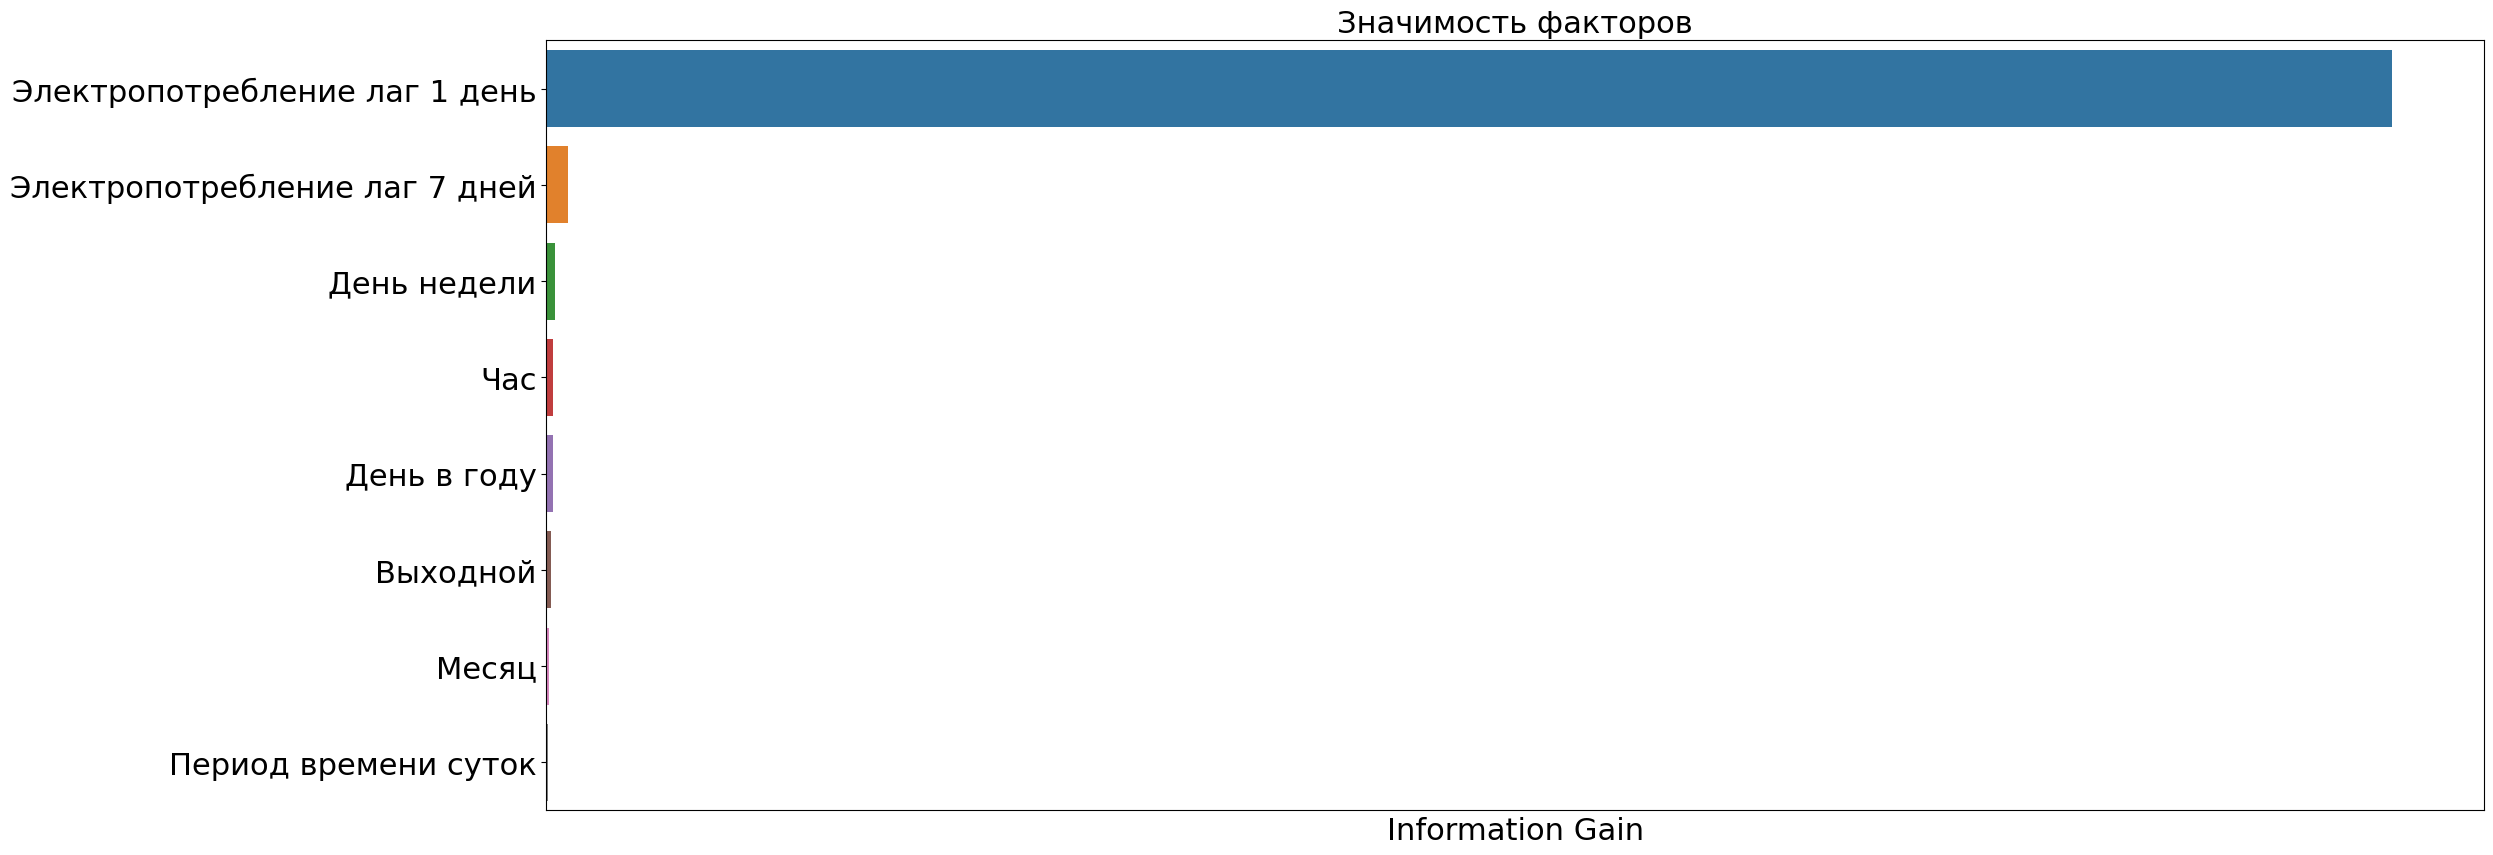

In [111]:
plt.figure(figsize=(25, 10))
ax2 = sns.barplot(data=data, x='information gain', y=data.index)
ax2.xaxis.set_major_locator(NullLocator())
plt.title('Значимость факторов', fontsize=22)
plt.xlabel('Information Gain', fontsize=22)
plt.yticks(fontsize=22)
plt.show()

<Axes: >

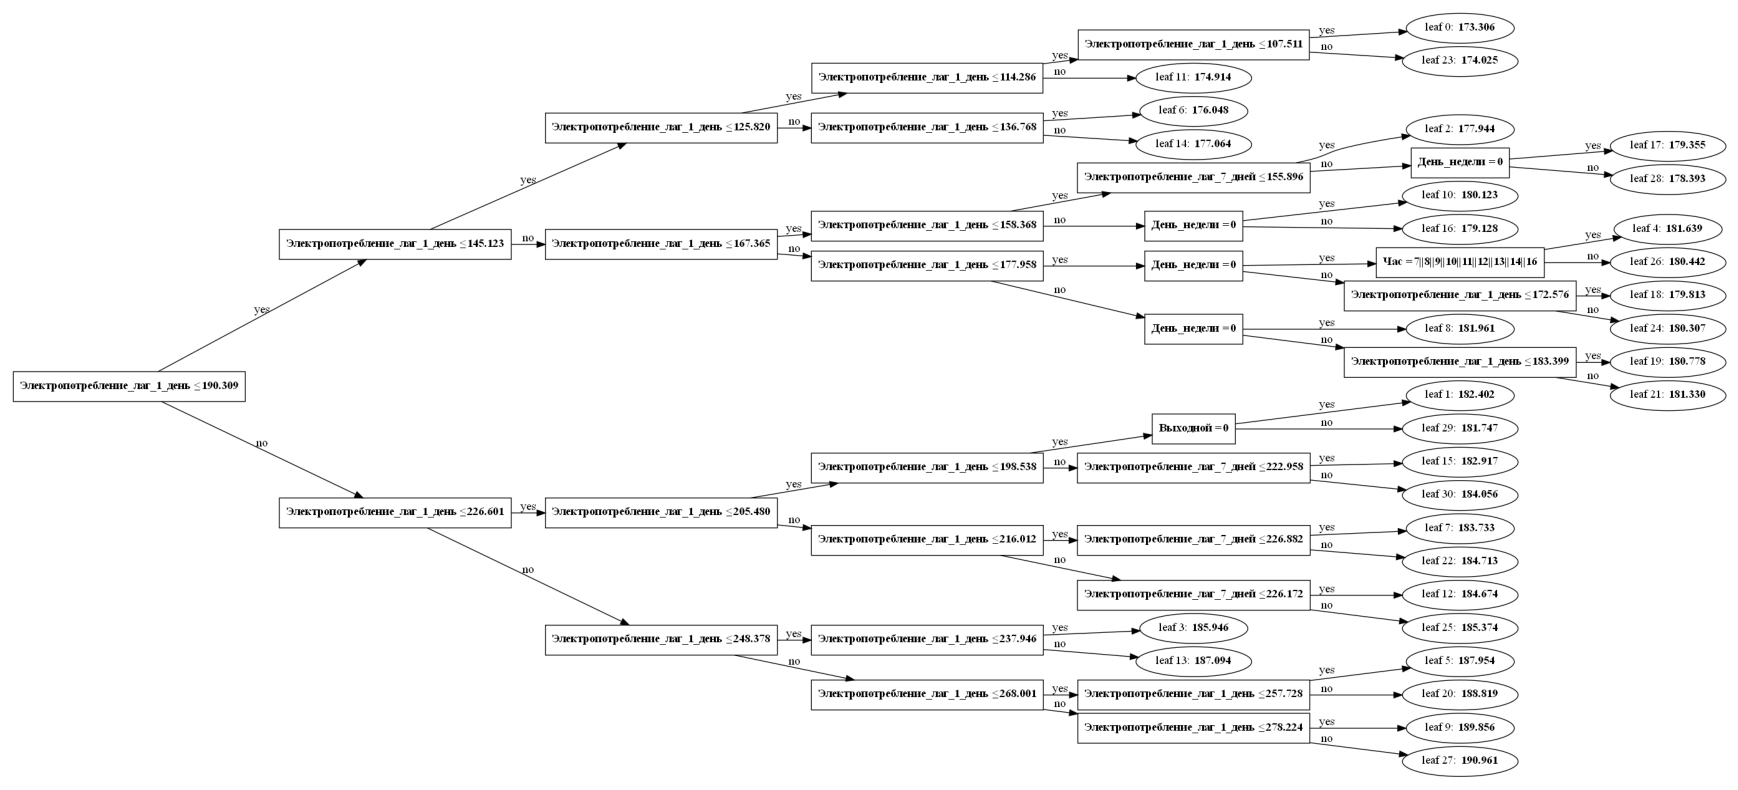

In [112]:
plot_tree(lgbm, figsize=(25, 10))

<h1><b>Оценка модели</b></h1>

In [23]:
def evaluate(y_f, y_r, k):
    # MSE = mean_squared_error(y_f, y_r)
    # print(f'MSE равняется {MSE:.3f}')
    RMSE = mean_squared_error(y_f, y_r, squared=False)
    print(f'RMSE равняется {RMSE:.3f}')
    MAE = mean_absolute_error(y_f, y_r)
    print(f'MAE равняется {MAE:.3f}')
    MAPE = mean_absolute_percentage_error(y_f, y_r) * 100
    print(f'MAPE равняется {MAPE:.3f} %')
    N = len(y_r)
    Adj_R2 = 1 - (N - r2_score(y_f, y_r) * N - 1 +
                  r2_score(y_f, y_r)) / (N - k - 1)
    print(f'Adjusted R2 равняется {Adj_R2:.3f}')

<h2>Метрики на обучающей выборке</h2>

In [113]:
y_pred_train = lgbm.predict(X_train)
evaluate(y_train, y_pred_train, len(X_train.columns))

RMSE равняется 6.180
MAE равняется 4.493
MAPE равняется 2.490 %
Adjusted R2 равняется 0.978


<h2>Метрики на валидации</h2>

In [38]:
def time_series_cv(model, X, y):
    tscv = TimeSeriesSplit(test_size=24 * 30 * 3, n_splits=5, gap=24 * 5)
    scikit_learn_metrics = [
        'neg_root_mean_squared_error', 
        'neg_mean_absolute_error',
        'neg_mean_absolute_percentage_error', 
        'r2']
    ds_metrics = [
        'RMSE', 
        'MAE',
        'MAPE', 
        'R2 adj']
    for scikit_learn_metric, ds_metric in zip(scikit_learn_metrics, ds_metrics):
        crs = cross_val_score(
            model,
            X,
            y,
            scoring=scikit_learn_metric,
            cv=tscv,
            n_jobs=-1)
        if scikit_learn_metric in ('neg_root_mean_squared_error', 'neg_mean_absolute_error'):
            print(f"{ds_metric} = {np.round(np.abs(crs).mean(), 3)} +- {np.round(np.abs(crs).std(), 3)}")
        elif scikit_learn_metric == 'neg_mean_absolute_percentage_error':
            print(f"{ds_metric} = {np.round(np.abs(crs).mean() * 100, 3)} +- {np.round(np.abs(crs).std() * 100, 3)}")
        elif scikit_learn_metric == 'r2':
            print(f"{ds_metric} = {np.round(crs.mean(), 3)} +- {np.round(crs.std(), 3)}")

In [114]:
time_series_cv(lgbm, X_train, y_train)

RMSE = 7.49 +- 0.889
MAE = 5.328 +- 0.544
MAPE = 2.893 +- 0.388
R2 adj = 0.944 +- 0.016


<h2>Метрики на тестовой выборке</h2>

In [115]:
y_pred_test = lgbm.predict(X_test)
evaluate(y_test, y_pred_test, len(X_test.columns))

RMSE равняется 8.172
MAE равняется 5.777
MAPE равняется 2.847 %
Adjusted R2 равняется 0.970


<h2>Метрики качества модели </h2>
<table>
  <tr>
    <td></td>
    <td><b>Train</b></td>
    <td><b>Validation</b></td>
    <td><b>Test</b></td>
  </tr>
  <tr>
    <td><b>RMSE</b></td>
    <td>6.180</td>
    <td>7.490</td>
    <td>8.172</td>
  </tr>
  <tr>
    <td><b>MAE</b></td>
    <td>4.493</td>
    <td>5.328</td>
    <td>5.777</td>
  </tr>
  <tr>
    <td><b>MAPE (%)</b></td>
    <td>2.490</td>
    <td>2.893</td>
    <td>2.847</td>
  </tr>
  <tr>
    <td><b>R<sup>2</sup><sub>adj</sub></b></td>
    <td>0.978</td>
    <td>0.944</td>
    <td>0.970</td>
  </tr>
</table>

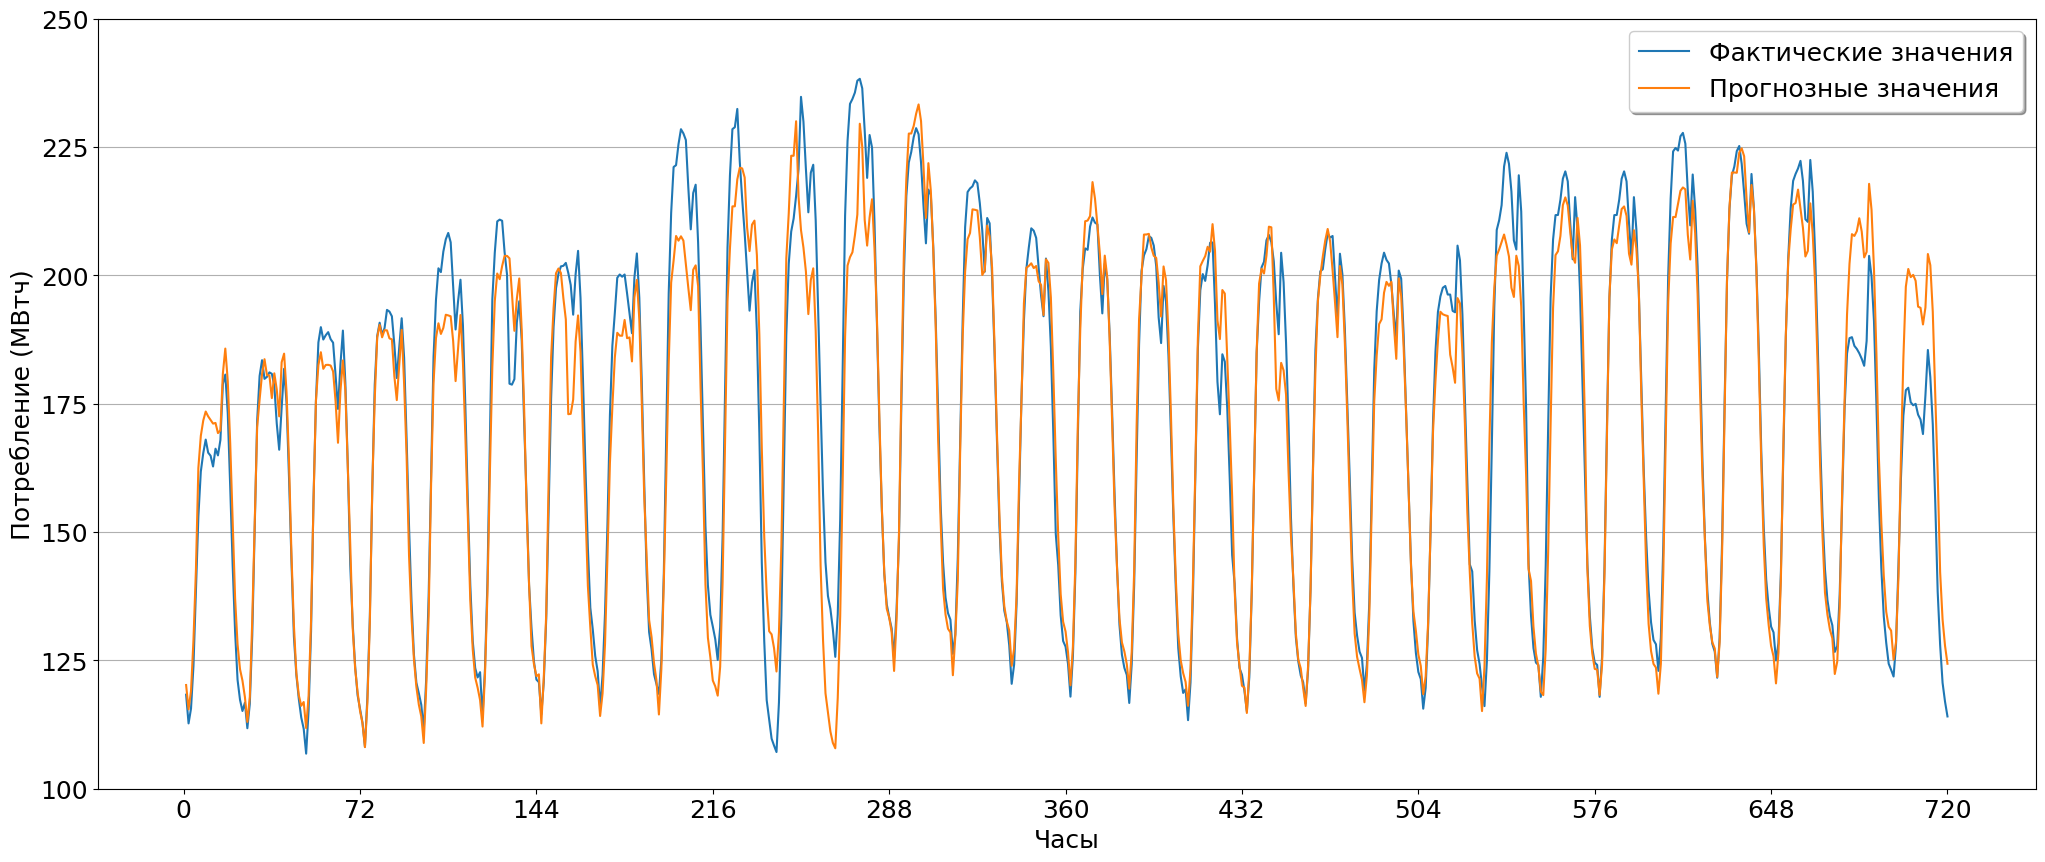

In [118]:
plt.figure(figsize=(25, 10))
horizon_size = 24 * 30
x_range = np.arange(1, horizon_size + 1)
plt.plot(x_range, y_test[:horizon_size], label='Фактические значения')
plt.plot(x_range, y_pred_test[:horizon_size], label='Прогнозные значения')
plt.yticks(np.arange(100, 275, 25), fontsize=18)
plt.ylabel('Потребление (МВтч)', fontsize=18)
plt.xticks(np.arange(0, 721, 24 * 3), fontsize=18)
plt.xlabel('Часы', fontsize=18)
plt.legend(loc='best', fontsize=18, shadow=True)
plt.grid(axis='y')
plt.show()

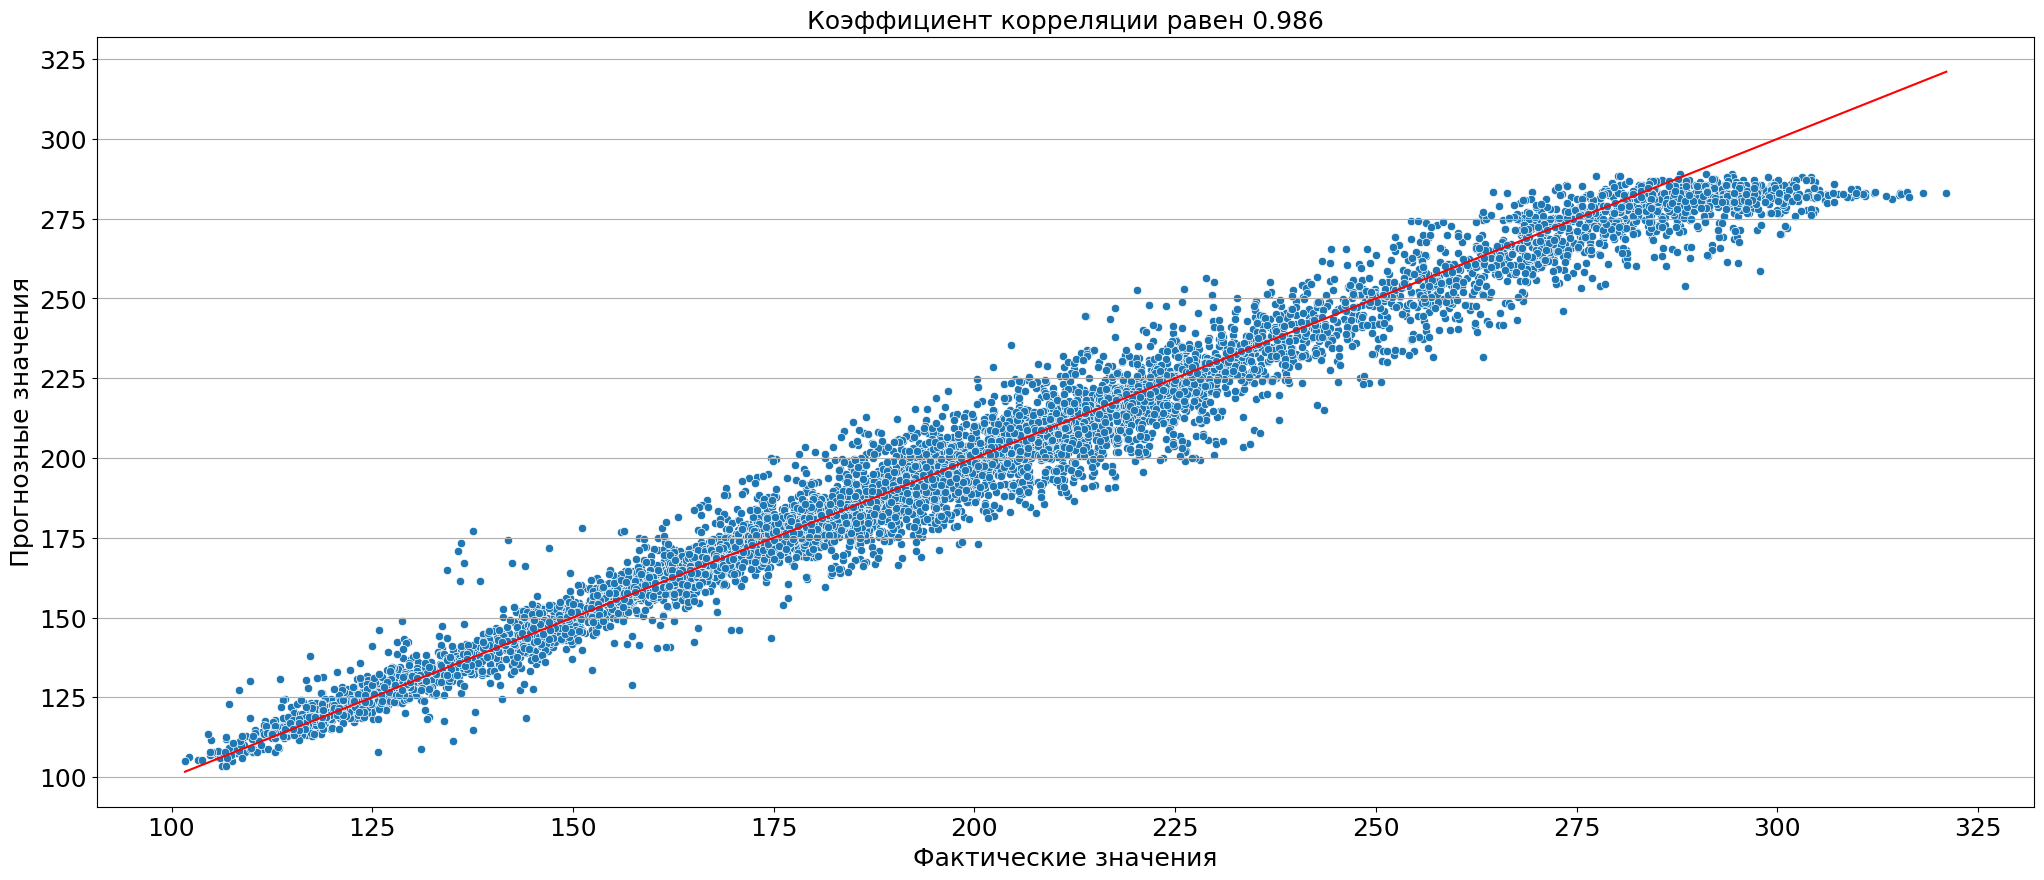

In [119]:
coef_corr = np.corrcoef(y_test.values, y_pred_test)[0, 1]
plt.figure(figsize=(25, 10))
plt.title(f'Коэффициент корреляции равен {coef_corr:.3f}', fontsize=18)
sns.scatterplot(x=y_test, y=y_pred_test)
plt.xlabel('Фактические значения', fontsize=18)
plt.ylabel('Прогнозные значения', fontsize=18)
plt.xticks(np.arange(100, 350, 25),fontsize=18)
plt.yticks(np.arange(100, 350, 25), fontsize=18)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], color='red')
plt.grid(axis='y')
plt.show()

<h1><b>Анализ остатков</b></h1>

In [120]:
errors = y_test - y_pred_test
errors

31540   -1.879671
31541   -2.739405
31542   -3.425389
31543   -5.030359
31544   -3.825518
           ...   
39379    5.143458
39380    6.707695
39381    5.831426
39382    6.254673
39383    4.037348
Name: Электропотребление, Length: 7844, dtype: float64

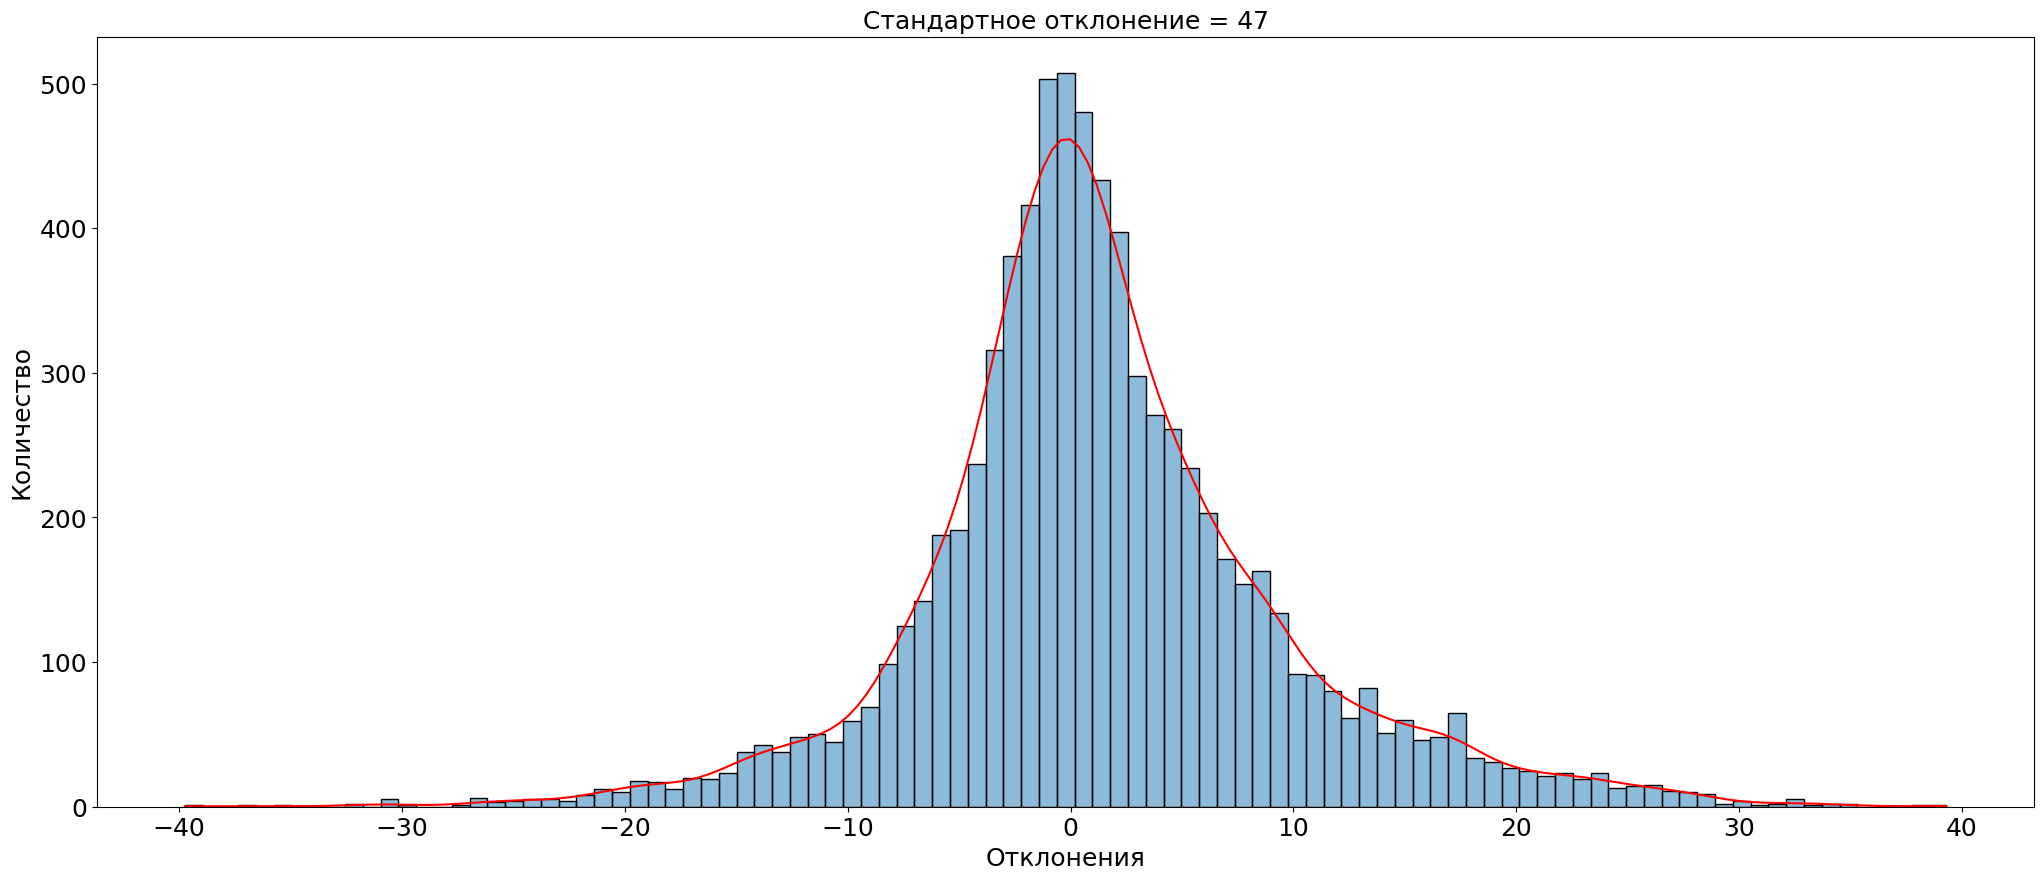

In [121]:
plt.figure(figsize=(25, 10))
ax = sns.histplot(x=errors, kde=True)
ax.lines[0].set_color('red')
plt.title(f'Стандартное отклонение = {np.round(y_test.std()).astype("int")}', fontsize=18)
plt.xticks(np.arange(-40, 50, 10), fontsize=18)
plt.xlabel('Отклонения', fontsize=18)
plt.yticks(np.arange(0, 600, 100), fontsize=18)
plt.ylabel('Количество', fontsize=18)
plt.show()

<h2>Отклонения не превышают 1 sd.</h2>

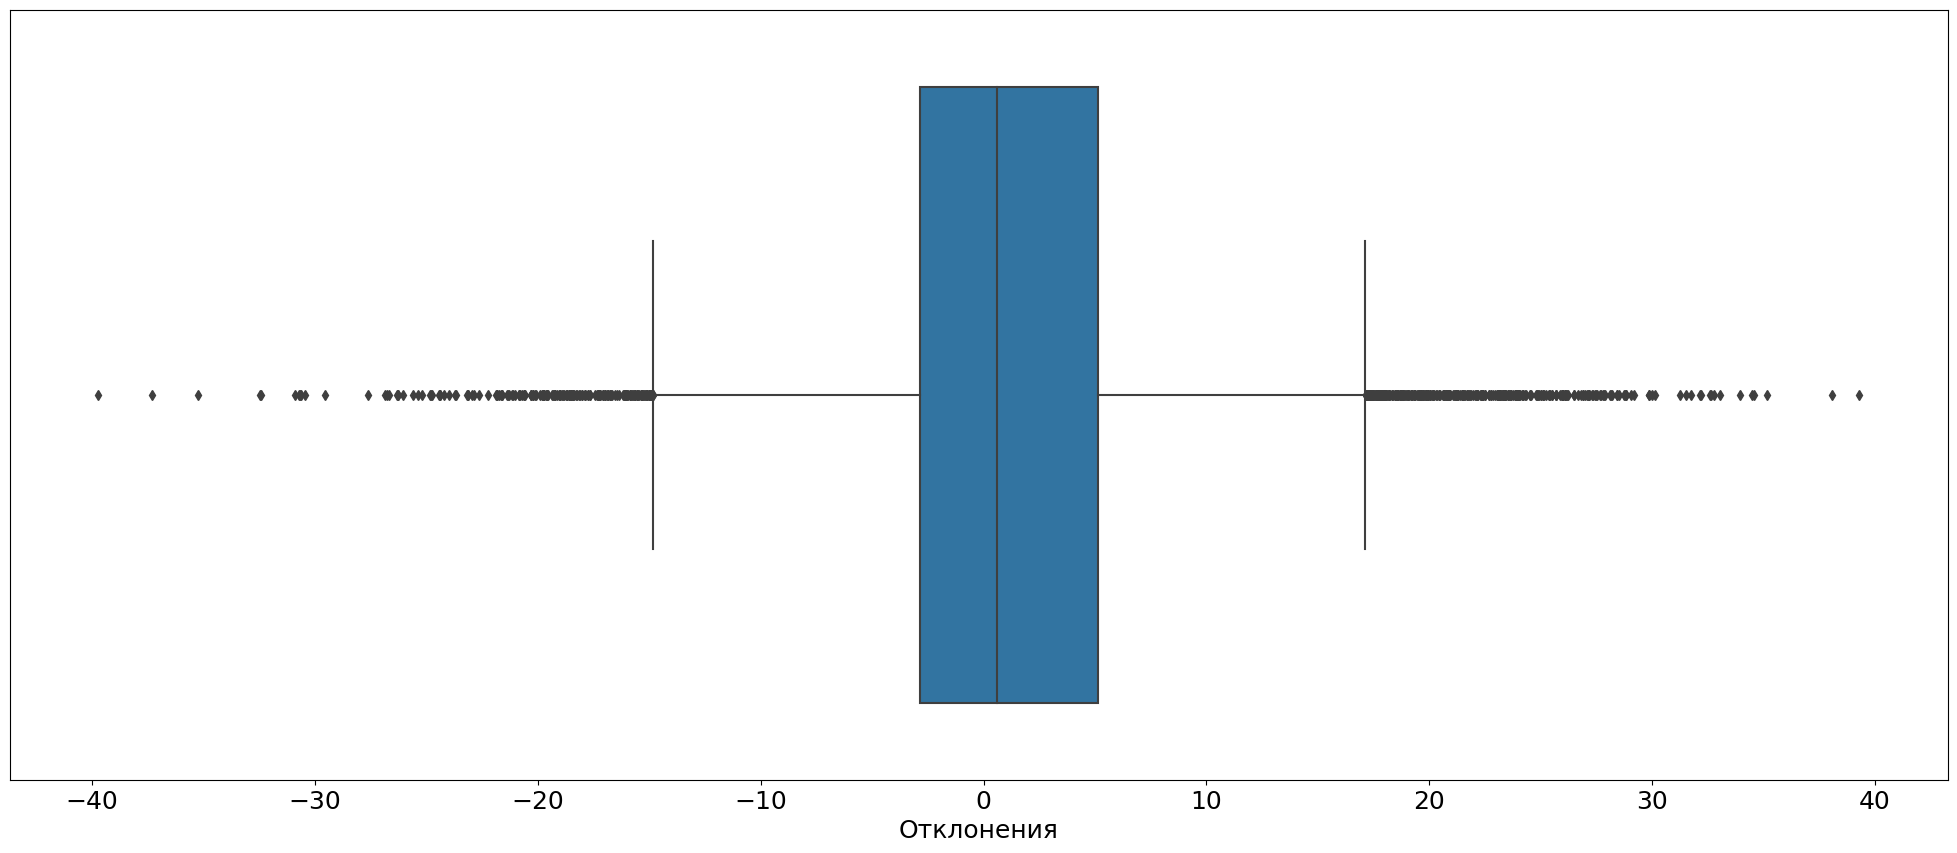

In [122]:
plt.figure(figsize=(25, 10))
ax3 = sns.boxplot(pd.DataFrame(errors), orient='h')
ax3.yaxis.set_major_locator(NullLocator())
plt.xticks(np.arange(-40, 50, 10), fontsize=18)
plt.xlabel('Отклонения', fontsize=18)
plt.show()

In [123]:
IQR = errors.quantile(q=0.75) - errors.quantile(q=0.25)
rh = errors.quantile(q=0.75) + IQR * 1.5
lh = errors.quantile(q=0.25) - IQR * 1.5
round(IQR, 3)

7.986

In [124]:
extra_outliers = errors[(errors > rh) | (errors < lh)]
extra_outliers

31672   -24.419120
31673   -17.866273
31696    27.537375
31697    25.103339
31739    18.206367
           ...    
38586    20.845560
38587    23.534794
38588    22.143642
38591    17.431404
39326   -14.855080
Name: Электропотребление, Length: 527, dtype: float64

In [125]:
round(len(extra_outliers) / len(y_pred_test) * 100, 3)

6.719

<h2>6.719 % тестовых прогнозов превышают норму.</h2>

In [126]:
max_positive_error = (y_test - y_pred_test).max()
max_negative_error = (y_test - y_pred_test).min()
print(f'Максимальная положительная ошибка {max_positive_error:.3f}')
print(f'Максимальная отрицательная ошибка {max_negative_error:.3f}')

Максимальная положительная ошибка 39.296
Максимальная отрицательная ошибка -39.733
